### MET Volume thresholds


Applying volume thresholds and looking at distribution of METs across treatments

In [9]:
#Read in file
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import sys 

#print versions of libraries
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

merged_df = pd.read_csv("./MFP_IV_combined_raw_data.csv")

#define a function to get get radius given volume 
def get_radius(volume):
    return (3*volume/(4*np.pi))**(1/3)

#add a column for radius
merged_df['radius_met'] = merged_df['Volume corrected'].apply(get_radius)
#normalized min distance to radius_met
merged_df['min_dist_norm'] = merged_df['min_dist'] / merged_df['radius_met']
merged_df.head()



Python version: 3.10.14 | packaged by Anaconda, Inc. | (main, Mar 21 2024, 16:20:14) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.2.1
Seaborn version: 0.13.2
Numpy version: 1.23.4
Matplotlib version: 3.8.4


C:\Users\rajasekhar.p\AppData\Local\Temp\ipykernel_18084\4029646829.py:15: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("./MFP_IV_combined_raw_data.csv")


,MET_ID,1,10,11,100,101,110,111,Volume corrected,min_dist,...,treatment,total_lung_volume,vessel_volume,vessel_surface_area,minor_axis,major_axis,elongation,met_type_cat,radius_met,min_dist_norm
0,28.0,0.011735,0.167993,0.0,0.511050,0.000000,0.309223,0.0,2.202260e+08,0.000000,...,IV,2.775850e+10,8.529756e+08,1.510170e+08,161.040177,337.000000,2.092645,polyclonal,374.622027,0.000000
1,50.0,0.998808,0.001192,0.0,0.000000,0.000000,0.000000,0.0,6.563523e+04,282.432010,...,IV,2.775850e+10,8.529756e+08,1.510170e+08,13.000000,18.336258,1.410481,polyclonal,25.023581,11.286634
2,89.0,0.175399,0.099498,0.0,0.545721,0.179381,0.000000,0.0,1.246517e+08,15.761827,...,IV,2.775850e+10,8.529756e+08,1.510170e+08,167.418006,376.000000,2.245876,polyclonal,309.886884,0.050863
3,119.0,0.974494,0.001366,0.0,0.024140,0.000000,0.000000,0.0,1.326004e+06,0.000000,...,IV,2.775850e+10,8.529756e+08,1.510170e+08,37.469744,55.000000,1.467851,polyclonal,68.153062,0.000000
4,125.0,0.975769,0.000219,0.0,0.024012,0.000000,0.000000,0.0,1.016321e+07,0.000000,...,IV,2.775850e+10,8.529756e+08,1.510170e+08,76.533946,111.000000,1.450337,polyclonal,134.373652,0.000000


In [10]:
merged_df.columns

Index(['MET_ID', '1', '10', '11', '100', '101', '110', '111',
       'Volume corrected', 'min_dist', 'max_dist', 'mean_dist',
       'Nearest Vessel Thickness', 'Vessel Volume', 'Clone1', 'Clone2',
       'Clone3', 'Clone4', 'Clone5', 'Clone6', 'Clone7', 'Box.X.Min',
       'Box.X.Max', 'Box.Y.Min', 'Box.Y.Max', 'Box.Z.Min', 'Box.Z.Max',
       'MetNum_that_touches', 'number_of_touchPoints', 'total_touching_volume',
       'total_touching_surface_area/2', 'centroid_x', 'centroid_y',
       'centroid_z', 'id', 'clone_type', 'treatment', 'total_lung_volume',
       'vessel_volume', 'vessel_surface_area', 'minor_axis', 'major_axis',
       'elongation', 'met_type_cat', 'radius_met', 'min_dist_norm'],
      dtype='object')

In [ ]:
#if column 'total_touching_surface_area/2' is 0, then set Vessel volume to 0 om cprresponding row
merged_df['vessel_volume_corrected'] = np.where(merged_df['total_touching_surface_area/2'] == 0, 0, merged_df['Vessel Volume'])

#Divide Volume corrected by total_lung_volume to get percentage of lung volume occupied by METs and add a column: perc_lung_vol
merged_df["perc_lung_vol"] = merged_df['Volume corrected']/merged_df['total_lung_volume']


Distribution of Volume of METs: Raw and vol normalized to lung vol
(NOT IN PAPER)

Text(0, 0.5, 'Frequency')

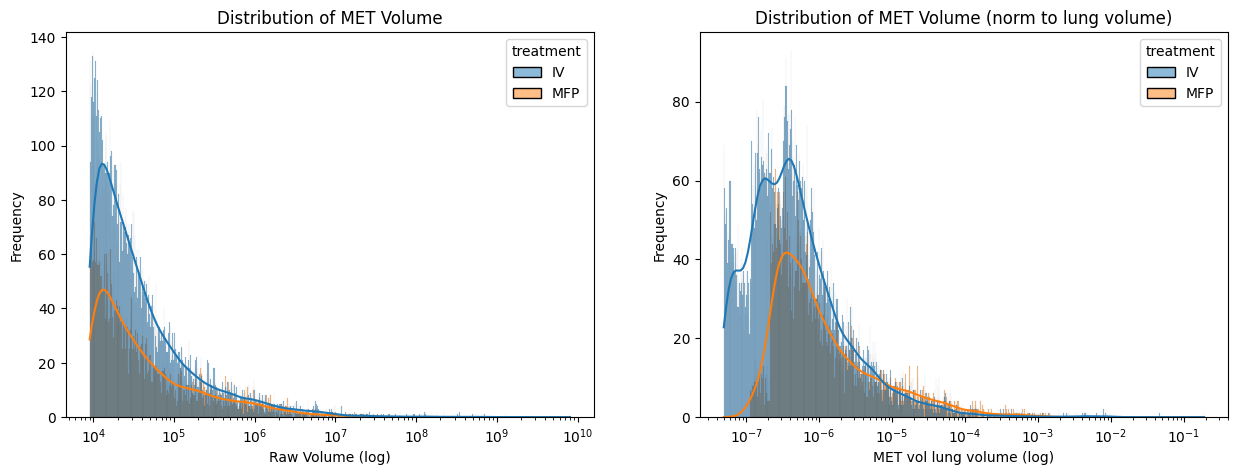

In [16]:

sns.color_palette("tab10")

#side by side histograms of IV vs MFP with y as perc_lung_vol and Volume corrected
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(merged_df, x='Volume corrected', bins=1000, log_scale=(True, False),kde=True, hue='treatment',palette='tab10',ax=ax[0])
ax[0].set_title('Distribution of MET Volume')
ax[0].set_xlabel('Raw Volume (log)')
ax[0].set_ylabel('Frequency')

sns.histplot(merged_df, x='perc_lung_vol', bins=1000, log_scale=(True, False),kde=True, hue='treatment',palette='tab10',ax=ax[1])
ax[1].set_title('Distribution of MET Volume (norm to lung volume)')
ax[1].set_xlabel('MET vol lung volume (log)')
ax[1].set_ylabel('Frequency')




We try a few different volume thresholds and examine the disttribution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


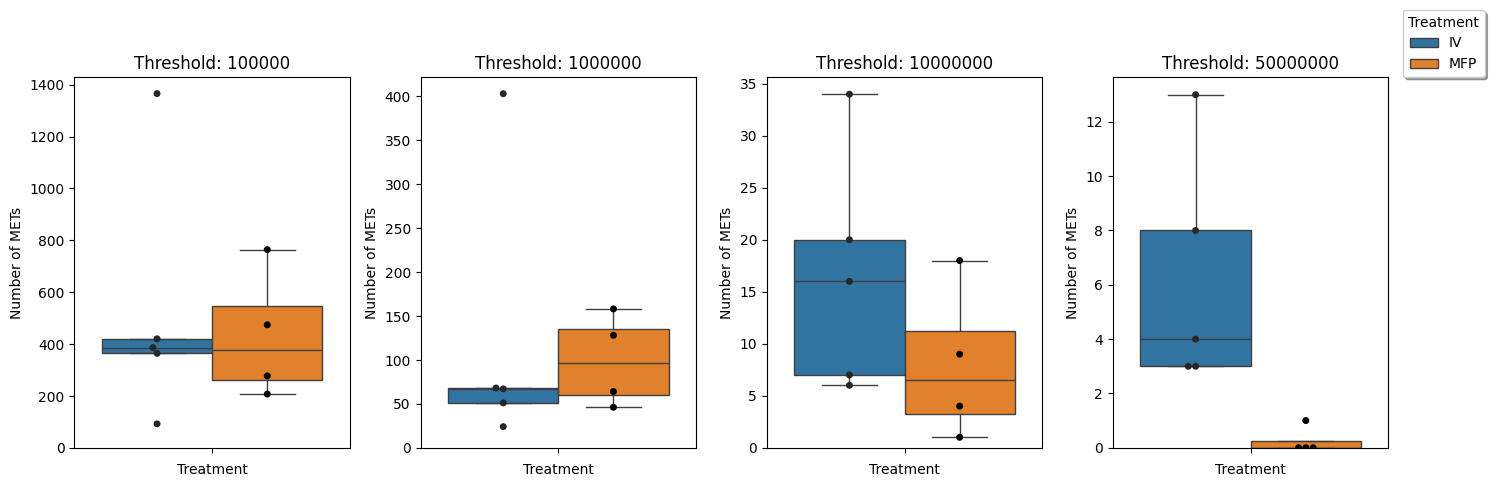

In [97]:
#loop through thresholds get volume for each threshold and compare the counts of the 2 treatments
thresholds = [ 10**5, 10**6, 10**7, 5*10**7]#

list_of_counts = []
#get unique treatment and id pairs
unique_treatment_id = merged_df[['treatment','id']].drop_duplicates()
df_dict = {} #store the dataframes for each threshold so we can use it to calculate stats
#plot in multiple subplots based on threshold lenght
fig, axs = plt.subplots(1,len(thresholds), figsize=(15,5))
for i,threshold in enumerate(thresholds):
    values = merged_df[merged_df['Volume corrected']>threshold]
    #if a treatment id pair is not in the values, then set the count to 0
    lol = values.groupby(['treatment','id']).size().reset_index(name='counts')
    lol = pd.merge(unique_treatment_id, lol, on=['treatment','id'], how='left').fillna(0)
    df_dict[threshold] = lol
    sns.boxplot(data=lol, hue='treatment', y='counts', ax=axs[i],showfliers=False)
    sns.swarmplot(data=lol, hue='treatment', y='counts', ax=axs[i], palette='dark:black',dodge=True,legend=False)
    axs[i].set_title(f"Threshold: {threshold}")
    axs[i].set_ylabel("Number of METs")
    axs[i].set_xlabel("Treatment")
    axs[i].get_legend().remove()
    axs[i].set_ylim(0,None)
#legend outside the plot for all subplots
plt.legend(title='Treatment', loc='upper center', bbox_to_anchor=(1.2, 1.2), shadow=True)
fig.tight_layout()
plt.savefig("./final_graphs/fig3/fig3_opqr_met_no_vol_thresholds.eps", format="eps",dpi=300)

STATS

In [70]:
#run stats on each dataframe in dfs
from scipy.stats import ttest_rel,ttest_ind
for df_val in df_dict.items():
    df = df_val[1]
    iv_counts = df[df['treatment']=='IV']['counts']
    mfp_counts = df[df['treatment']=='MFP']['counts']
    print(f"Threshold: {df_val[0]}")
    print("T-test unpaired")
    ttest_iv_mfp = ttest_ind(iv_counts,mfp_counts)
    print("IV vs MFP",ttest_iv_mfp)

Threshold: 100000
T-test unpaired
IV vs MFP TtestResult(statistic=0.3516545443661102, pvalue=0.7354449686502135, df=7.0)
Threshold: 1000000
T-test unpaired
IV vs MFP TtestResult(statistic=0.28336201280366957, pvalue=0.7850965334904946, df=7.0)
Threshold: 10000000
T-test unpaired
IV vs MFP TtestResult(statistic=1.295783773624013, pvalue=0.2361381285586072, df=7.0)
Threshold: 50000000
T-test unpaired
IV vs MFP TtestResult(statistic=2.6998677702639564, pvalue=0.03064489012323005, df=7.0)


In [83]:
#convert dictionary with values as dataframe to a dataframe
df_dict_df = pd.concat(df_dict).reset_index().drop('level_1',axis=1)
df_dict_df['threshold'] = df_dict_df['level_0']
#drop level_0
df_dict_df.drop('level_0',axis=1,inplace=True)
df_dict_df.to_csv("./final_graphs/fig3/fig3_opqr_met_no_vol_thresholds_data.csv", index=False)

-----------------------

OTHER exploratory data analysis

We tried a few different thresholds and settled on a few above for ease of comparison in the paper

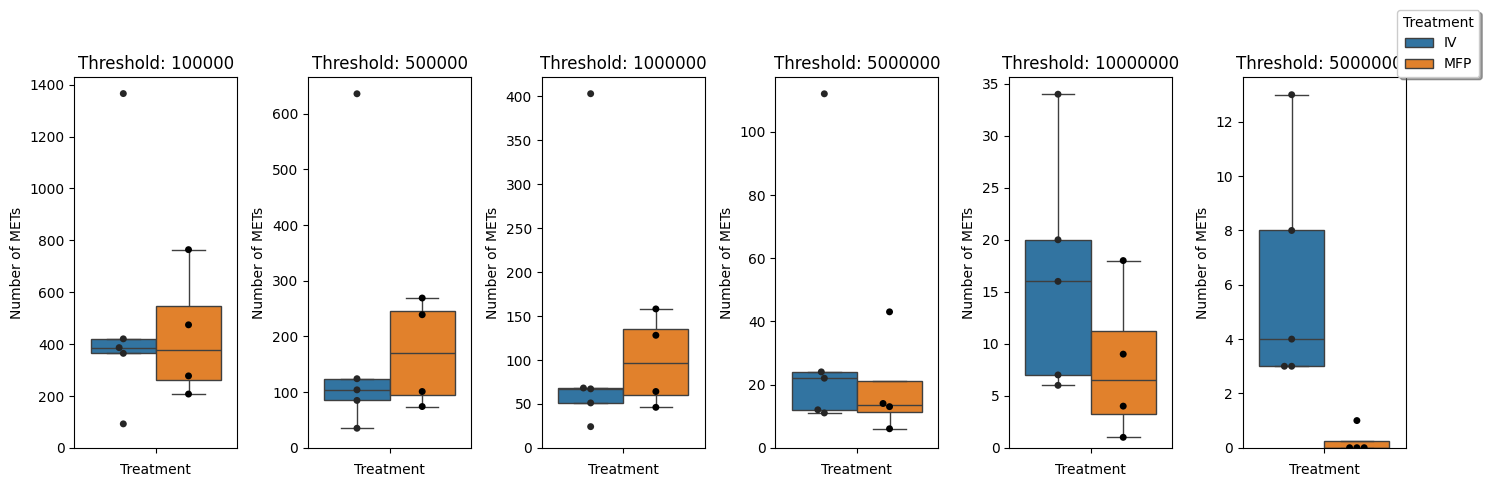

In [98]:
#loop through thresholds get volume for each threshold and compare the counts of the 2 treatments
thresholds = [ 10**5, 5*10**5, 10**6, 5*10**6, 10**7, 5*10**7]#

list_of_counts = []
#get unique treatment and id pairs
unique_treatment_id = merged_df[['treatment','id']].drop_duplicates()
df_dict = {} #store the dataframes for each threshold so we can use it to calculate stats
#plot in multiple subplots based on threshold lenght
fig, axs = plt.subplots(1,len(thresholds), figsize=(15,5))
for i,threshold in enumerate(thresholds):
    values = merged_df[merged_df['Volume corrected']>threshold]
    #if a treatment id pair is not in the values, then set the count to 0
    lol = values.groupby(['treatment','id']).size().reset_index(name='counts')
    lol = pd.merge(unique_treatment_id, lol, on=['treatment','id'], how='left').fillna(0)
    df_dict[threshold] = lol
    sns.boxplot(data=lol, hue='treatment', y='counts', ax=axs[i],showfliers=False)
    sns.swarmplot(data=lol, hue='treatment', y='counts', ax=axs[i], palette='dark:black',dodge=True,legend=False)
    axs[i].set_title(f"Threshold: {threshold}")
    axs[i].set_ylabel("Number of METs")
    axs[i].set_xlabel("Treatment")
    axs[i].get_legend().remove()
    axs[i].set_ylim(0,None)
#legend outside the plot for all subplots
plt.legend(title='Treatment', loc='upper center', bbox_to_anchor=(1.2, 1.2), shadow=True)
fig.tight_layout()

Cumulative distribution of MET volume

Text(0.5, 1.0, 'Cumulative Distribution of Metastasis Volume')

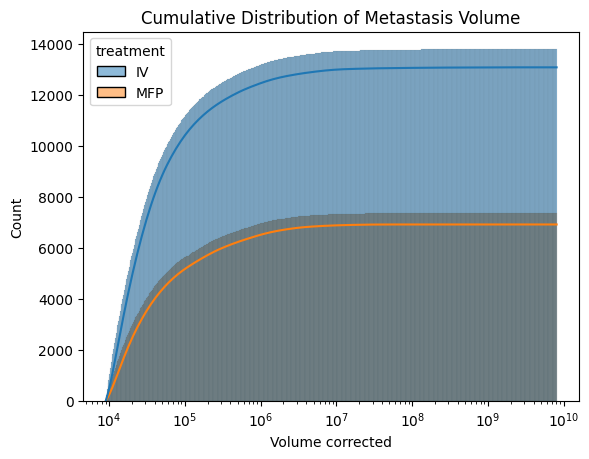

In [84]:
#cumulative distribution of MET volume
sns.histplot(merged_df, x='Volume corrected', bins=1000, log_scale=(True, False),kde=True,cumulative=True, hue='treatment',palette='tab10')
plt.title("Cumulative Distribution of Metastasis Volume")
#plt.savefig("./final_graphs/fig3/fig3_cumulative_distribution_met_volume.eps", format="eps",dpi=300)


(0.0, 1.0)

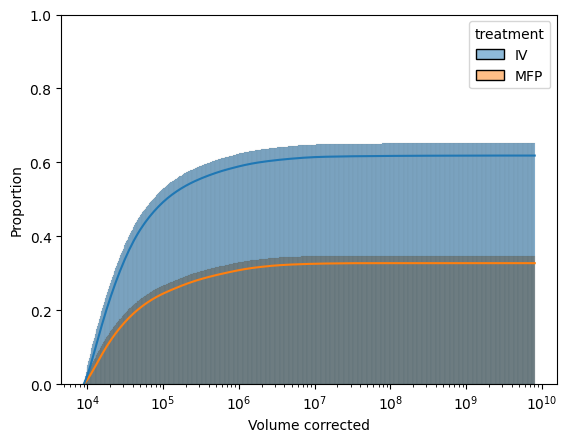

In [112]:
sns.histplot(merged_df, x='Volume corrected', bins=1000, log_scale=(True, False),kde=True,cumulative=True, hue='treatment',palette='tab10',stat='proportion')
#0 to 1
plt.ylim(0,1)

it looks like IV has more METs and much smaller METs compared to MFP.
 But, we need to account for the distribution of METs across animals. i.e., some animals may have more METs than others and can skew the data

<Axes: xlabel='Volume corrected', ylabel='Proportion'>

c:\Users\rajasekhar.p\Miniconda3\envs\spatialdata\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\rajasekhar.p\Miniconda3\envs\spatialdata\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


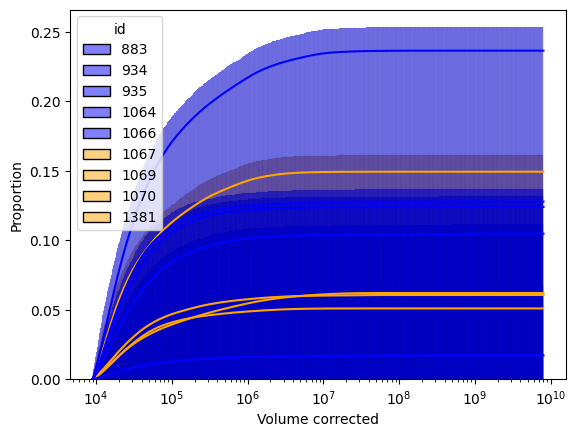

In [113]:
#plot histplot kde, hue should be treatment, but each id should be plotted
palette_dict = dict(zip(merged_df['id'], merged_df['treatment'].map({'IV': 'blue', 'MFP': 'orange'})))

sns.histplot(merged_df, x='Volume corrected', bins=1000, log_scale=(True, False),kde=True, hue='id',cumulative=True,palette=palette_dict,stat=
            'proportion')

<Axes: xlabel='Volume corrected', ylabel='Proportion'>

c:\Users\rajasekhar.p\Miniconda3\envs\spatialdata\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


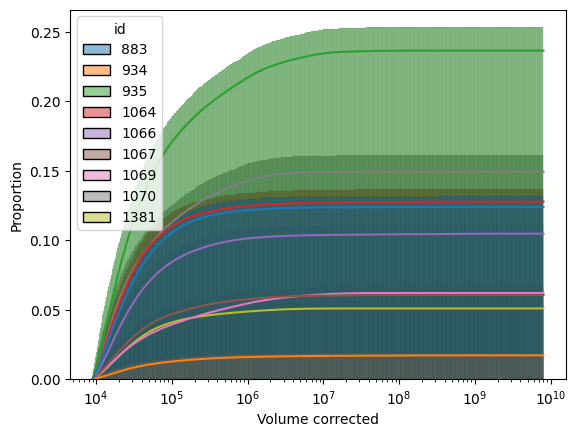

In [114]:
sns.histplot(merged_df, x='Volume corrected', bins=1000, log_scale=(True, False),kde=True,cumulative=True, hue='id',palette='tab10',stat='proportion')


Looks like 935 is contributing a lot. However, most MFP are lower than IV